Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Close
2.00000    292
3.00000    235
2.12500    228
1.87500    208
3.25000    159
          ... 
5.09375      1
4.57000      1
4.58000      1
4.46000      1
4.11000      1
Name: count, Length: 690, dtype: int64


Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64


(8030, 60, 5) (8030,) (2008, 60, 5) (2008,)


Epoch 1/20


C:\Users\plo55\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0030 - val_loss: 8.0818e-05
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.7687e-04 - val_loss: 6.1520e-05
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.4499e-04 - val_loss: 1.1359e-04
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.3219e-04 - val_loss: 5.7974e-05
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.2829e-04 - val_loss: 5.0647e-05
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.0597e-04 - val_loss: 1.0906e-04
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.1162e-04 - val_loss: 5.5032e-05
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 9.6908e-05 - val_loss: 4.6447e-05
Epoch 9/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.0489e-04 - val_loss: 5.0885e-05
Epoch 10/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.3978e-05 - val_loss: 4.4517e-05
Epoch 11/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.

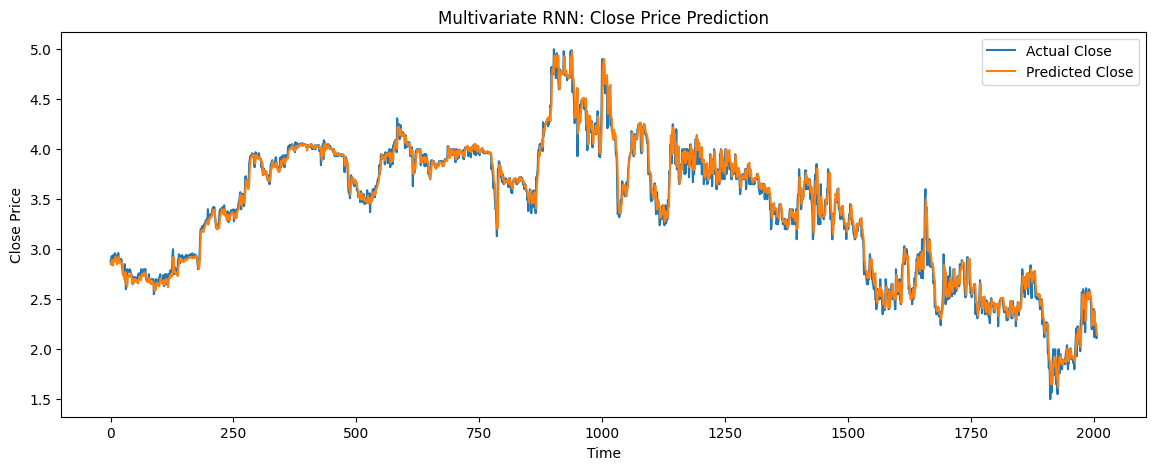



📉 Test MSE: 0.0090
📉 Test MAE: 0.0647


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

'''
입력: 60일간의 Open, High, Low, Close, Adj Close

출력: 그 다음 날의 Close

모델: LSTM(64) → Dense(1)

정규화: 전체 입력에 대해 정규화, 출력은 Close 위치만 역정규화

지표 출력: MSE, MAE
'''

# 데이터 불러오기
url = 'https://github.com/MyungKyuYi/AI-class/raw/main/AAME.csv'
df = pd.read_csv(url)

# 컬렴명 확인
print(df.columns)
print("\n=====================================================\n")

# 레이블 갯수 확인 (숫자)
print(df['Close'].value_counts())
print("\n=====================================================\n")

# 결측치 확인
print(data.isnull().sum())
print("\n=====================================================\n")

# 'Date'와 'Volume' 열 제거
df.drop(columns=['Date', 'Volume'], inplace=True, errors='ignore')

# 입력 변수와 타겟 변수 분리
features = ['Open', 'High', 'Low', 'Close', 'Adj Close']
target_col = 'Close'

data = df[features].copy()
data.dropna(inplace=True)

# 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 시퀀스 생성 함수 (다변수용)
def create_sequences_multivariate(data, seq_length, target_index):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, target_index])  # Close 위치 예측
    return np.array(X), np.array(y)

seq_length = 60
target_index = features.index(target_col)  # 'Close'가 몇 번째 열인지
X, y = create_sequences_multivariate(scaled_data, seq_length, target_index)

# 학습/테스트 데이터 분할
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 학습/테스트 데이터 shape 확인
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("\n=====================================================\n")

# ✅ RNN 모델 구성
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(60, 5))) # 이전 60일치의 데이터, 5개의 특성으로
model.add(Dense(1)) # 다음날 Close 예측 (회귀)

# 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error') # 회귀: mse
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 8. 예측 및 역정규화
predictions = model.predict(X_test)
# 역정규화를 위해 'Close' 컬럼만 다시 정규화
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[target_index], scaler.scale_[target_index]

predictions_rescaled = close_scaler.inverse_transform(predictions)
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# 시각화
plt.figure(figsize=(14,5))
plt.plot(y_test_rescaled, label='Actual Close')
plt.plot(predictions_rescaled, label='Predicted Close')
plt.title('Multivariate RNN: Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 예측 결과 역정규화된 상태에서 MAE, MSE 계산
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print("\n=====================================================\n")
print(f"📉 Test MSE: {mse:.4f}")
print(f"📉 Test MAE: {mae:.4f}")